In [1]:
from shfl.data_base.emnist import Emnist

database = Emnist()
train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(type(train_data[0]))
train_data[0].shape

Using TensorFlow backend.


200000
40000
40000
<class 'numpy.ndarray'>


(28, 28)

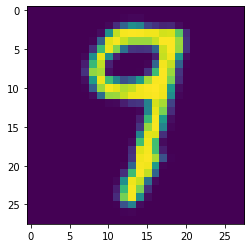

In [2]:
import matplotlib.pyplot as plt

plt.imshow(train_data[0])

In [3]:
import shfl
import numpy as np

class NumberOfInstances(shfl.private.FederatedTransformation):
        
    def apply(self, labeled_data):
        print(len(labeled_data.label))
        
        
class UniqueLabels(shfl.private.FederatedTransformation):
        
    def apply(self, labeled_data):
        classes = [label.argmax(-1) for label in labeled_data.label]
        print(np.unique(classes))
        

# I.I.D. Federated Sampling

In the IID scenario, each node has independent and identically distributed access to all observations in the dataset.

The only available choices are:
1. Percentage of the dataset used.
2. Number of instances per node.
3. Sampling with or without replacement.


## Percentage of the dataset used in a i.i.d scenario

The *percent* parameter indicates the percentage of the total number of observation in the datased splitted across the different clients. Since the subset is chosen randomly, it statistically becomes representative and follows the same distribution that the whole dataset. Obviously, it **can not be** neither greated than 100 or lesser than 0.


## Number of instances per node in a i.i.d scenario

The *weight* parameter indicates the deterministic distribution of the number of samples per node, as a ratio over the total number of observations in the dataset used for the simulation. For instance, *weights = [0.2, 0.3, 0.5]* means that the first node will be assigned a 20% of the total number of observations in the dataset used, the second node a 30% and the third node a 50%. 

Note that the *weight* parameter must not necessarily sum up to one, because of the option of *sampling*. We specify this fact below.


## Sampling with or without replacement

The *sampling* parameter, which can have one of the following two values *'with_replacement'* or *'without_replacement'*, indicates if an observation assigned to a particular node is removed from the dataset pool and thereof, it will be assigned only once (*weight = 'without_replacement'*); or will be back to the dataset pool and thereof, it could be selected for a new asignation (*weight = 'with_replacement'*).

## Combinations of the *weights* and *sampling* parameters

### *sampling = 'without_replacement'* 

When *sampling = 'without_replacement'* the total number of samples assigned to the nodes **can not be** greater than the number of available observations in the dataset. This imposes the constraint on the *weights* parameter than the sum of the *weights* values should be equal to or lesser than one. If they are not, the weights will be normalised to sum 1.  The possible cases are:

1. If the sum of the *weights* values is lesser than one when *sampling = 'without_replacement'* then, the resulting distribution of observations to the nodes (the union of the nodes sets of samples) is a subset of the raw dataset of the whole percentage used.



In [4]:
from shfl.data_distribution.data_distribution_iid import IidDataDistribution

iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.1,0.2,0.3])

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
12000
24000
36000


2. If the sum of the *weights* values is equal to one when *sampling = 'without_replacement'* then, the resulting distribution of observations to the nodes (the union of the nodes sets of samples) is exactly the raw dataset, that is, the distributed samples conform a partition of the original dataset.

In [5]:
iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.3,0.3,0.4])

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
36000
36000
48000


3. If the sum of the *weights* values is greater or lesser than one when *sampling = 'without_replacement'* then, the *weights* values will be normalised to sum up to one. For instance, giving *sampling = 'without_replacement'* and *weights = [0.2, 0.3, 0.7]* the sum of the *weights* values is 1.2 > 1, and thereof, the effective *weights* values will result of the normalization: *weights = [0.2/1.2, 0.3/1.2, 0.7/1.2]*.

In [6]:
iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.2,0.3,0.7])

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
20000
30000
70000


### *sampling = 'with_replacement'* 

When *sampling = 'with_replacement'* the total number of samples assigned to the nodes **can be** greater or lesser than the number of available observations in the dataset. This removes any constraint on the *weights* parameter values. The resulting distribution of samples across the nodes are subsets of the original dataset that could share observations and also, each node could have none, one or more than one samples of a given observation.

In [7]:
iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.5,0.3,0.7], 
                                                                            sampling = "with_replacement")

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
60000
36000
84000


# Non-I.I.D. Federated Sampling

In contrast to the IID scenario, where the concept was quite clear, the data can be non-IID for several reasons \:

1. **Non-identical client distributions**: this is the case when data distributions from several clients do not follow the same probability distribution. The difference in probability distributions can be due to several factors:
   
   1.1. *Feature distribution skew*: when data features of several clients follow different probability distribution. This case is typical of personal data, such as handwritten digits.
   
   1.2. *Label distribution skew*: when label distribution vary across different clients. This kind of skew is typical of area-dependent data (species existing in a certain place).
   
   1.3. *Concept shift*: when the data features with the same label differs accross different clients (same features, different label), i.e. due to cultural differences or when label from data with the same features differs accross different clients (same label, different features), i.e. due to personal preferences. 
   
   1.4. *Unbalancedness*: it is common that the amount of data varies significantly between clients.
   
2. **Non-independent client distributions**: when the distribution of data from some clients depend in some way on the distribution of data from another. For example, cross-device FL experiments are performed at night local time which causes a geographic bias in the data.

3. **Non-identical and non-independent distributions**:  in real FL scenarios, data may be non-IID for several reasons simultaneously due to the particular nature of the data source.


As we have introduced, the reasons why a dataset may be non-IID are manifold. For the moment, the framework implements *label distribution skew*. For each client, we randomly choose the number of labels it knows and which ones they are. We show the labels known by each client.

In this case, the options available are the same and have the same meaning as in the I.I.D sampling. According to the *sampling* parameter, when *sampling = 'whithout_replacement'*, due to non-I.I.D restrcitions (clients with reduced number of known labels), it is possible that some clients receive less data than specified by the weights parameter due to the lack of more data from a certain label. 


In [8]:
from shfl.data_distribution.data_distribution_non_iid import NonIidDataDistribution

non_iid_distribution = NonIidDataDistribution(database)
federated_data, test_data, test_label = non_iid_distribution.get_federated_data(num_nodes=3, percent = 50,
                                                                            weights=[0.2,0.3,0.7])

print(type(federated_data))
print(federated_data.num_nodes())
print("Number of instances per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, NumberOfInstances())

<class 'shfl.private.federated_operation.FederatedData'>
3
Number of instances per client:
20000
23987
70000


Let's see the labels that know each clients in order to show the label distribution skew.

In [9]:
print("Known labels per client:")
shfl.private.federated_operation.apply_federated_transformation(federated_data, UniqueLabels())

Known labels per client:
[2 4]
[4 9]
[0 3 4 7 8 9]
